In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# feature_name_df.head(3)

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])
feature_name_df.head(20)

In [2]:
# 중복 피처명 확인중복 피처명 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [3]:
# cumcount() 몇번째 중복인지 확인

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('../Data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용 #\s+ 공백이 하나 이상인 것
    X_train = pd.read_csv('../Data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('../Data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('../Data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('../Data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [7]:
#y_train의 class 분포 확인
print(y_train['action'].value_counts()) # 비교적 고르게 분포되어 있음

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [10]:
X_train.isna().sum().sum()

0

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [13]:
df_clf = DecisionTreeClassifier(random_state = 156)
df_clf.fit(X_train,y_train)
pred = df_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('결정트리 예측 정확도 : {0:.4}'.format(accuracy))

결정트리 예측 정확도 : 0.8548


In [14]:
# 현재 모델의 하이퍼파라미터의 설정 확인
df_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 156,
 'splitter': 'best'}

In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6,8,10,12,16,20]
}

# cv=5로 설정 # verbose=1
grid_cv = GridSearchCV(df_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=156),
             param_grid={'max_depth': [6, 8, 10, 12, 16, 20]},
             scoring='accuracy', verbose=1)

In [19]:
print('GridSearchCV 최고 평균 정확도 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 파라미터 :', grid_cv.best_params_)

GridSearchCV 최고 평균 정확도 : 0.8513
GridSearchCV 최적 파라미터 : {'max_depth': 16}


In [26]:
## depth 단계마다 평균 정확도 확인
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800


In [28]:
params = {
    'max_depth' : [6,8,10,12,16,20]
}

for depth in max_depth :
    df_clf=DecisionTreeClassifier(max_depth=depth,random_state=156)
    df_clf.fit(X_train,y_train)
    pred = df_clf.predict(X_test)
    accuracy=accuracy_score(y_test,pred)
    print('max_depth = {0} 정확도:{1:.4f}'.format(depth,accuracy))

max_depth = 6 정확도:0.8558
max_depth = 8 정확도:0.8707
max_depth = 10 정확도:0.8673
max_depth = 12 정확도:0.8646
max_depth = 16 정확도:0.8575
max_depth = 20 정확도:0.8548
max_depth = 24 정확도:0.8548


In [30]:
params = {
    'max_depth' : [8, 10, 12],
    'min_samples_split' : [16, 24]
}

# cv=5로 설정 # verbose=1
grid_cv = GridSearchCV(df_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 파라미터 :', grid_cv.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


GridSearchCV 최고 평균 정확도 : 0.8549
GridSearchCV 최적 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [33]:
best_df_clf = grid_cv.best_estimator_ # 최적파라미터 모델
pred_fin = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred_fin)
print('예측 정확도:{0:.4f}'.format(accuracy))

예측 정확도:0.8717


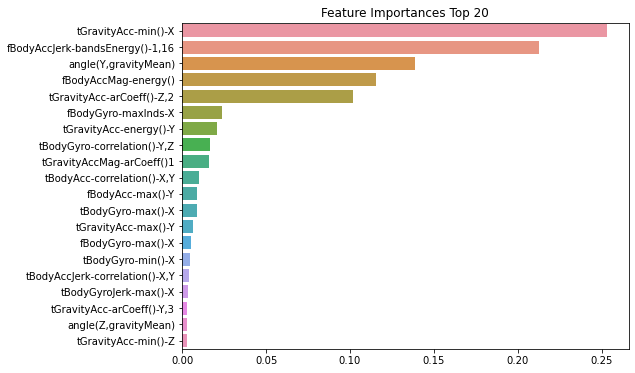

In [34]:
import seaborn as sns

feature_importance_values = best_df_clf.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=X_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top20 = feature_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 20')
sns.barplot(x=feature_top20, y=feature_top20.index)
plt.show()